In [1]:
# load necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import pickle
import glob

from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (10, 10)

## Specify file and folder locations

In [2]:
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"
clFile = 'data/letter-slope-classifications_10nov2017.csv'
savefile = "accuracy.pkl"

consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
# consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
consensusCsvFiles = glob.glob('{}/*.csv'.format(consensusFolder))
consensusCsvFiles = [i for i in consensusCsvFiles if "linewise" in i]

## Run segmentation loop

In [ ]:
# subject file
subj = readSubjFile(subjFile)
# classification export
clExp = readSlopeClassification(clFile)

for consensusFile in consensusCsvFiles:
    ##############################################################################################
    # Read data files
    # consensus file (by line)
    cons = readConsensusFile(consensusFile)
    # combine data files
    idAndUrl, telegrams = mergeSubjAndCons(subj, cons, clExp)
    
    ##############################################################################################
    # collect the data for the wordbreaks
    data = {}

    for im in list(idAndUrl.index):
        hdl_id = idAndUrl.loc[im, "hdl_id"]
        data[hdl_id] = {}
        print(hdl_id)

        data[hdl_id]["url"] = idAndUrl.loc[im, "url_cons"]
        linesForTele = telegrams.loc[telegrams["hdl_id"] == hdl_id]
        linesForTele.loc[:,"y1"] = [np.mean(eval(l))
                                    for l in linesForTele.loc[:,"y_loc"]]


        # read in and do all pre-processing #################################
        let, grey = readImg(idAndUrl.loc[im, "url_cons"])
        grey, let2, thresh_inf = removeEdges(grey, let, 35.0)
        grey = grey['soft']#thresh_inf['greyWhitened']['soft']
        greySm = smoothImg(grey, sigma=5.0)
#         greyBi = binarizeImg(grey, biThresh=skimfilt.threshold_otsu)
#         greyBiSm = smoothImg(greyBi, sigma=5.0)


        # get linebreaks ####################################################
        matchlim = 30
        lb = projBreaks(greySm, "y")
        lb = filterBreaks(lb, matchlim)
        data[hdl_id]["lb"] = lb

        break
        # get matching lines with actual lines ##############################
        actuallb = linesForTele.loc[:, "y1"]
        matches = matchLines(lb, actuallb)
        data[hdl_id]["matches"] = matches

        # get wordbreaks ####################################################
        accur = wordBreaks(grey, lb, matches, linesForTele)
        data[hdl_id]["segment"] = accur
        print()
        
        # save object
#         with open(savefile, "wb") as f:
#             pickle.dump(data, f)
        break
    break

## check breakage

In [3]:
def matchLines(lb, actuallb, yoffset, matchlim = 30):
    matches = []
    lb2 = np.add(lb, yoffset)
    for i in range(len(lb)):
        closest = np.argmin(np.abs(np.subtract(lb2[i], actuallb)))
        if np.abs(lb2[i] - actuallb[closest]) < matchlim:
            matches.append(closest)
        else:
            matches.append(-1)
    return matches


nuOpt = np.arange(0.5, 6.5, 0.5) # 0.5:6.5
biOpt = list(range(1, 10)) # 1:10

def wordBreaks(grey, lb, matches, linesForTele, nuOpt=nuOpt, biOpt=biOpt):
    accurL = []

    for i in range(1, len(lb)):
        print(i, end=" ")
        if matches[i] == -1:
            continue
        chunk = grey[lb[i-1]:lb[i],]
        rw = linesForTele.loc[matches[i],"consensus_text"]
        # remove leading and trailing "
        if rw[0] == '"':
            rw = rw[1:]
        if rw[-1] == '"':
            rw = rw[:-1]
        nr = len(rw.split(" "))
        for nu in nuOpt:
            for bi in biOpt:
                br = gaussBreaks(chunk, nu=nu, biThresh=bi, shear=0, fix=0)
                accurL.append({"lb_index":i, "nu":nu, "biThresh":bi, "n_words_cons":nr,
                               "breaks":br, "n_words_gauss": len(br)})
    return pd.DataFrame(accurL)

In [5]:
# subject file
subj = readSubjFile(subjFile)
# classification export
clExp = readSlopeClassification(clFile)

for consensusFile in consensusCsvFiles:
    # consensusFile = consensusCsvFiles[0]
    #################################################################################
    # Read data files
    # consensus file (by line)
    cons = readConsensusFile(consensusFile)
    # combine data files
    idAndUrl, telegrams = mergeSubjAndCons(subj, cons, clExp)

    ##############################################################################################
    # collect the data for the wordbreaks
    data = {}

    for im in list(idAndUrl.index):
    #     im = list(idAndUrl.index)[0]
        hdl_id = idAndUrl.loc[im, "hdl_id"]
        data[hdl_id] = {}
        print(hdl_id)

        data[hdl_id]["url"] = idAndUrl.loc[im, "url_cons"]
        linesForTele = telegrams.loc[telegrams["hdl_id"] == hdl_id]
        linesForTele.loc[:,"y1"] = [np.mean(eval(l))
                                    for l in linesForTele.loc[:,"y_loc"]]

        # read in and do all pre-processing #################################
        let_orig, grey_orig = readImg(idAndUrl.loc[im, "url_cons"])
        grey2, let2, thresh_details = removeEdges(grey_orig, let_orig, 35.0)
        grey = grey2['soft']
        let = let2['soft']
        greySm = smoothImg(grey, 7.0)
        #         greyBi = binarizeImg(grey, biThresh=skimfilt.threshold_otsu)
        #         greyBiSm = smoothImg(greyBi, sigma=5.0)

        # get linebreaks ####################################################
        matchlim = 30
        lb = projBreaks(greySm, "y")
        lb = filterBreaks(lb, matchlim)
        data[hdl_id]["lb"] = lb

        # get matching lines with actual lines ##############################
        actuallb = linesForTele.loc[:, "y1"]
        yoffset = thresh_details['level2TrimOffsets']['soft'][0]
        matches = matchLines(lb, actuallb, yoffset)
        data[hdl_id]["matches"] = matches

        # get wordbreaks ####################################################
        accur = wordBreaks(grey, lb, matches, linesForTele)
        data[hdl_id]["segment"] = accur
        print()

#         save object
        with open(savefile, "wb") as f:
            pickle.dump(data, f)
        break
    break

mssEC_02_007
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 


# Previous work

In [16]:
accur.loc[:,'mynr'] = [len(i) for i in accur.loc[:,'br']]

In [19]:
len(accur.loc[accur.loc[:,'mynr'] == accur.loc[:,'nr']])

181

In [11]:
offsets = thresh_details['level2TrimOffsets']['soft'][0]
offsets
# greyTrimmed = {label : grey[mask].reshape(np.count_nonzero(xProjectedL2Mask[label]),
#                                                np.count_nonzero(yProjectedL2Mask[label]))
#                     for label, mask in level2TrimMask.items() }

{'hard': (86, 0), 'soft': (68, 0)}

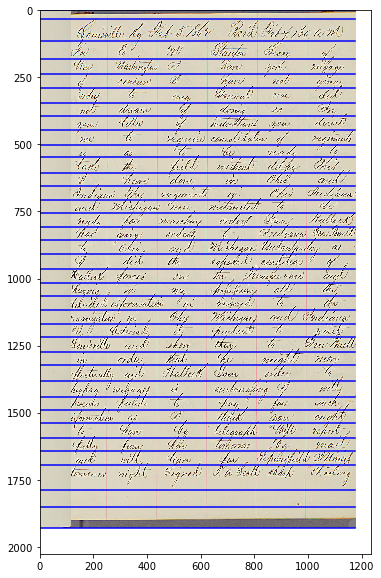

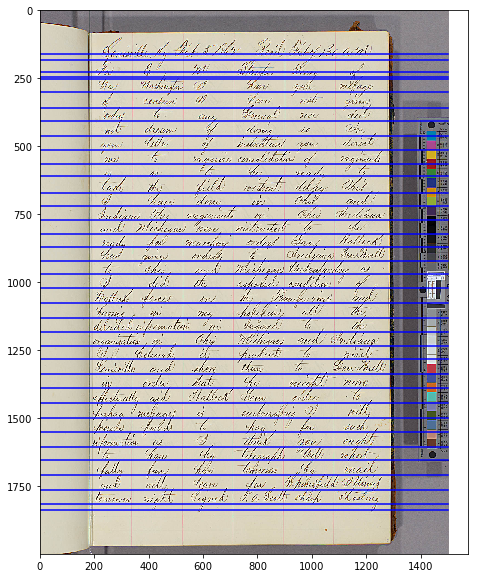

In [10]:
plotBoxes(let, lb)
plotBoxes(let_orig, actuallb)